# MBTI Personality Predictor using Machine Learning

## Step 1 :- Import Libraries

In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import string

# Feature Extraction
import gensim
from gensim.utils import simple_preprocess

# Dimensionality reduction
from sklearn.decomposition import PCA

#Cross Validation
from sklearn.model_selection import StratifiedKFold

# Models
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Plot Metrics
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall



## Read data
### Load the dataset into a pandas dataframe.

In [19]:
df = pd.read_csv("/kaggle/input/mbti-type/mbti_1.csv")
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [24]:
# Count rows and columns in dataframe
df.shape

(8675, 2)

In [25]:
# Check null values
df.isnull().any()

type     False
posts    False
dtype: bool

In [26]:
# short summary of dataset
df.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [27]:
# count total non null values and type of each columns in dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


### Summary:
##### * Total columns in dataset - 2
##### * Total rows - 8675
##### * Null Values in both columns - 0
##### * All values in both column are in textual form 
##### * Total unique types of personality - 16 

In [28]:
# Count unique values in 'type' column
types = df.type.unique()
count = len(types)
print(f"In 'type' column {count} types of unique personalities are present that are {types}")

In 'type' column 16 types of unique personalities are present that are ['INFJ' 'ENTP' 'INTP' 'INTJ' 'ENTJ' 'ENFJ' 'INFP' 'ENFP' 'ISFP' 'ISTP'
 'ISFJ' 'ISTJ' 'ESTP' 'ESFP' 'ESTJ' 'ESFJ']


In [29]:
# Total posts for every personality personality
personality = df.groupby(['type']).count().sort_values('posts',ascending = False)
print("The Total Posts for every Personality Type")
personality

The Total Posts for every Personality Type


,posts
type,
INFP,1832
INFJ,1470
INTP,1304
INTJ,1091
ENTP,685
ENFP,675
ISTP,337
ISFP,271
ENTJ,231


### Data visualization

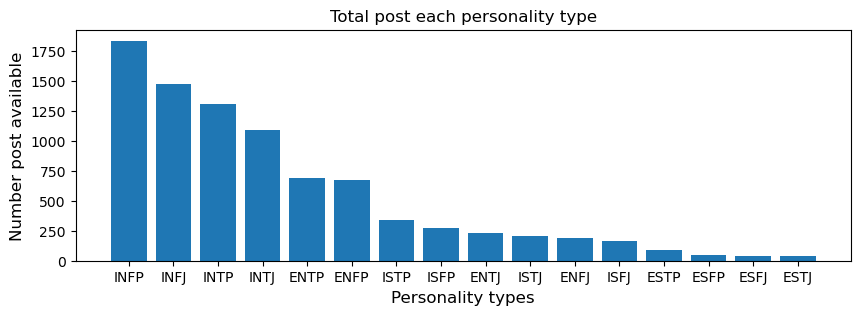

In [13]:
plt.figure(figsize = (10,3))
plt.bar(np.array(personality.index), height = personality['posts'])
plt.xlabel("Personality types", size = 12)
plt.ylabel('Number post available', size = 12)
plt.title('Total post each personality type')
plt.show();

This is 

## Data Preprocessing

#### Part 1-
1. Remove duplicate rows
2. Lowercasing
3. Remove URLs
4. Remove Punctuation

#### Part 2 -
1. Tokenization
2. Stemming / Lemmanization

#### Both stemming and lemmatization can be useful preprocessing techniques for word2vec, lemmatization is likely the better choice for a task like personality prediction where preserving the meaning of words is critical.

In [18]:
# Print first post
df['posts'][1]

"'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This + Lack of Balance and Hand Eye Coordination.|||Real IQ test I score 127. Internet IQ tests are funny. I score 140s or higher.  Now, like the former responses of this thread I will mention that I don't believe in the IQ test. Before you banish...|||You know you're an ENTP when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideas/thoughts. You know you're an ENTP when you...|||http://img188.imageshack.us/img188/6422/6020d1f9da

In [17]:
# Count total duplicate rows
df.duplicated().sum()

0

In [31]:
ps = PorterStemmer()

def clean_text(text):
    # Convert text into lowercase
    text = text.lower() 
    
    # Replace '|||' with ' '
    text = text.replace('|||'," ")
    
    # Remove url and numbers from the text
    pattern = re.compile(r'https?://\S+|www\.\S+|[0-9]') 
    text = pattern.sub(r'', text) 
    
    # Remove punctuation from the text 
    text = text.translate(str.maketrans("","",string.punctuation)) 
    
    # Word tokenization
    text = word_tokenize(text)
    
    # Stemming
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    
    return text

In [32]:
corpus = []
for i in range(0,len(df)):
    corpus.append(clean_text(df['posts'][i]))

#### Before Prepocessing

In [35]:
df['posts'][1]

"'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This + Lack of Balance and Hand Eye Coordination.|||Real IQ test I score 127. Internet IQ tests are funny. I score 140s or higher.  Now, like the former responses of this thread I will mention that I don't believe in the IQ test. Before you banish...|||You know you're an ENTP when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideas/thoughts. You know you're an ENTP when you...|||http://img188.imageshack.us/img188/6422/6020d1f9da

#### After preprocessing

In [34]:
corpus[1]

'im find lack post alarm sex bore posit often exampl girlfriend current environ creativ use cowgirl missionari isnt enough give new mean game theori hello entp grin that take convers flirt acknowledg presenc return word smooth wordplay cheeki grin lack balanc hand eye coordin real iq test score internet iq test funni score higher like former respons thread mention dont believ iq test banish know your entp vanish site year half return find peopl still comment post like ideasthought know your entp think thing sometim go old sherlock holm quot perhap man special knowledg special power like rather encourag seek complex cheshirewolftumblrcom post realli ive never thought ei jp real function judg use use ne ti domin fe emot rare si also use ni due strength know though ingeni say realli want tri see happen play first person shooter back drive around want see look rock paper one best make lol guy lucki im realli high tumblr system hear new first person shooter game ive rock hell soundtrack aut

## Feature Extraction / Vectorization
#### Methods for Feature Extraction
1. One Hot Encoding
2. Bag of Word (BOW)
3. n-grams
4. Term Frequency-Inverse Document Frequency (TF-IDF)
5. Word2Vec(Word Embedding)

In [16]:
### Applying Countvectorizer
# # Creating the Bag of wrord model
# from sklearn. feature_extraction.text import CountVectorizer
# cv = CountVectorizer(ngram_range = (1,3))
# X = cv.fit_transform(corpus).toarray()

# # Creating  word2vec



In [74]:
posts = []
for post in corpus:
    posts.append(simple_preprocess(post))
    

In [75]:
vec_model = gensim.models.Word2Vec(min_count=2)

In [80]:
vec_model.build_vocab(posts)

In [81]:
vec_model.train(posts, total_examples = vec_model.corpus_count, epochs = vec_model.epochs)

(24940270, 27296680)

In [88]:
# dimension (default is 100)
vec_model.wv['big'].shape

(100,)

In [91]:
# similarity between 2 words
vec_model.wv.similarity('king','lion')

0.8501599

In [83]:
# words similar to 'long'
vec_model.wv.most_similar('long')

[('loooong', 0.6295567154884338),
 ('longer', 0.6196164488792419),
 ('short', 0.577091634273529),
 ('extend', 0.5545302629470825),
 ('longest', 0.5508442521095276),
 ('awhil', 0.5482046008110046),
 ('forev', 0.5467679500579834),
 ('picturevers', 0.5052496790885925),
 ('length', 0.4914529621601105),
 ('hudr', 0.4905104637145996)]

In [84]:
# which one of these ('short', 'long')
vec_model.wv.doesnt_match(['short','long','tell'])

'tell'

In [87]:
# vector representation of word 'tell'
vec_model.wv['tell']

array([ 0.22283287,  1.8309436 ,  0.17788188,  0.22506869, -0.4778636 ,
       -1.2692513 ,  0.18666689, -1.0102806 ,  1.4195337 , -0.6067708 ,
        0.57170045, -0.33651525,  0.9944342 ,  0.6124984 , -0.65955806,
       -0.8568991 ,  0.20091684, -0.5664146 , -1.7461996 ,  1.374986  ,
        0.1994762 ,  0.00874553,  3.652256  ,  1.7868885 ,  0.38367411,
        1.2772905 , -0.2298909 , -1.5273392 ,  0.83221924, -0.6334843 ,
        0.82893276, -0.8271613 ,  0.16868344, -1.300727  , -1.0894084 ,
       -0.16690636,  0.97733146,  0.5074041 ,  1.0909455 ,  0.553994  ,
       -1.7941227 ,  1.9347048 , -1.9318795 , -0.92331856, -1.058133  ,
       -1.3461949 ,  2.8012433 , -0.19018948, -1.4520373 , -0.64754087,
        2.3525515 ,  0.32548672,  0.10219397,  0.43135482,  1.9407498 ,
       -1.2696452 , -0.39434168, -0.03466123,  0.36211756,  1.3379794 ,
       -2.3129406 , -0.7925084 ,  0.6562679 , -1.571125  , -1.9045372 ,
        0.80595565,  0.15147401,  0.37684348, -0.8593797 ,  0.53

In [95]:
# show unique words and the dimension
vec_model.wv.get_normed_vectors().shape

(108957, 100)

In [102]:
vec_model.wv.get_normed_vectors()

array([[-0.07533188,  0.06046781,  0.00504698, ..., -0.05712497,
         0.1265794 , -0.11427701],
       [-0.17393808,  0.17975724,  0.06862888, ...,  0.1788991 ,
         0.06137839,  0.06955112],
       [-0.14409472,  0.1273047 ,  0.1331097 , ...,  0.05165195,
         0.05110401,  0.13840272],
       ...,
       [ 0.06719629, -0.0561331 ,  0.12167132, ..., -0.04541469,
        -0.08390504,  0.09111955],
       [-0.13581909,  0.1048165 ,  0.08920475, ...,  0.07018723,
         0.09138541,  0.059503  ],
       [ 0.02901716,  0.14056753,  0.00135679, ..., -0.14889175,
        -0.00316261,  0.2061499 ]], dtype=float32)

## Dimensionality Reduction
The dimensionality of Word2Vector Model is too high due to which it is taking too much time for computation. 
So we need to reduce the dimensionality with the help of PCA algo

In [ ]:
pca = PCA(0.90)
x_pca = pca.fit_transform(vec_model.wv.get_normed_vectors())

In [ ]:
x_pca.shape

In [114]:
len(vec_model.wv.index_to_key)

108957

In [115]:
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in vec_model.wv.index_to_key]
    return np.mean(vec_model.wv[doc], axis = 0)

In [116]:
document_vector(df["posts"].values[0])

array([-0.19586289,  0.54147565,  0.05673565, -0.20118429,  0.02757179,
       -0.4716097 ,  0.4504027 ,  0.13297348,  0.14399818, -0.13512543,
        0.00993436, -0.10187386,  0.07737805,  0.0077037 ,  0.23149313,
       -0.11415387, -0.00361622, -0.08042374, -0.03824778,  0.16736156,
        0.0100109 ,  0.35990086,  0.1821056 , -0.25726917, -0.14962281,
        0.0158383 , -0.15939432, -0.45781592, -0.03901242, -0.01983191,
        0.13461368, -0.34457695,  0.100586  ,  0.05771132, -0.20178765,
       -0.1083543 ,  0.01355544, -0.0709091 ,  0.05220286, -0.14889951,
        0.22296593,  0.0187234 , -0.1696729 , -0.05003517, -0.1408111 ,
       -0.29232857,  0.23236239, -0.32907614,  0.2609062 , -0.20857616,
        0.03694626,  0.09443935,  0.11772867, -0.00804696,  0.40137348,
       -0.19018157,  0.17440732, -0.15945965,  0.04568507,  0.09873664,
       -0.2796003 , -0.2848663 , -0.40496635, -0.27022904,  0.09802783,
        0.19885172,  0.08721156, -0.11403066,  0.02097478,  0.00

In [ ]:
from tqdm import tqdm

X = []
for doc in tqdm(df["posts"].values):
    X.append(document_vector(doc))

## Model Training

### Following are some best alogorithm for classification problem
1. Random Forest Classifier
2. (Multinomial) Naive Bayes
3. Logistic Regression 

In [ ]:
# encode text data into numerical data
y = encoder.fit_transform(df['type'])

In [19]:
## Divide the dataset into train and test
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)


### RandomSearchCV

In [ ]:
# Number of trees in random forest
n_estimators = [20,60,100,120]

# Number of features to consider at every split
max_features = [0.2,0.6,1.0]

# Maximum number of Levels in tree
max_depth = [2,5,8]

# Number of samples
max_samples = [0.5,0.75,1.0]

In [ ]:
param_grid ={'n_estimator':n_estimators,
             'max_features', max_features,
             'max_depth', max_depth,
             'max_samples',max_samples    
}

### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()

rf_grid = RandomizedSearchCV(estimator = rf,
                      param_grid = param_grid,
                      cv = 5,
                      verbose = 2,
                      n_jobs = -1)

In [ ]:
rf_grid.fit(X_train,y_train)
rf_pred = rf_grid.predict(X_test)
f1score = f1_score(y_test, y_pred)
c_report = classification_report(y_test, y_pred)

# Plot metrics 
plot_roc(y_test, y_pred)
plt.show()
    
plot_precision_recall(y_test, y_pred)
plt.show()

In [ ]:
rf_grid.best_params_

In [ ]:
rf_grid.best_score_

## Multinomial Classification

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha = 0.1)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
f1score = f1_score(y_test, y_pred)
c_report = classification_report(y_test, y_pred)
score = accuracy_score(y_test, y_pred)

# Plot metrics 
plot_roc(y_test, y_pred)
plt.show()
    
plot_precision_recall(y_test, y_pred)
plt.show()

### Multinomial classifier with Hyperparameter

In [ ]:
previous_score = 0
for alpha in np.arange(0,1,0.1):
    sub_classifier = MultinomialNB(alpha = alpha)
    sub_classifier.fit(X_train,y_train)
    y_pred = sub_classifier.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    c_report = classification_report(y_test, y_pred)
    if score > previous_score:
        classifier = sub_classifier
    print('Alpha: {}, Accuracy Score: {} F1 score {} '.format(alpha,score,f1score))
    
    # Plot metrics 
    plot_roc(y_test, y_pred)
    plt.show()
    
    plot_precision_recall(y_test, y_pred)
    plt.show()
    